In [1]:
import MGTomo.model as mgmodel
import numpy as np
import time
import MGTomo.tomoprojection as mgproj
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize

import torch
from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_torch = torch.tensor(resize(x_orig, (N,N), anti_aliasing = False), requires_grad = True)

In [3]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 200, 'level_decrease' : 1})
fine_dim = model.dim
A = mgproj.TomoTorch(model.proj_factory(fine_dim))
b = A(x_torch)

In [4]:
#c0 = 56.0952
c0 = 100
#c0 = A.sumnorm()
tau0 = 0.5 * 1/c0

In [5]:
fh = lambda x: fcts.kl_distance(x, A, b)

In [8]:
z0 = torch.rand(N, N, requires_grad = True)
fhz0 = fh(z0).item()

iteration_times = []
overall_start_time = time.process_time()  # Start overall timing

fval = []

for i in range(100):
    iteration_start_time = time.process_time()  # Start timing for this iteration
    
    val = fcts.BSMART(fh, z0, tau0)
    z0 = val.clone().detach().requires_grad_(True)
    
    iteration_end_time = time.process_time()  # End timing for this iteration
    iteration_time = iteration_end_time - iteration_start_time  # Calculate elapsed time for this iteration
    iteration_times.append(iteration_time)

    fval.append(fh(z0).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time:.6f} seconds")

overall_end_time = time.process_time()  # End overall timing
overall_time = overall_end_time - overall_start_time  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time:.6f} seconds")

Iteration 0: 150471.94628673542 - Time: 5.896894 seconds
Iteration 1: 76824.76202274917 - Time: 5.807981 seconds
Iteration 2: 52160.10659900474 - Time: 6.134125 seconds
Iteration 3: 41226.28591225567 - Time: 5.867851 seconds
Iteration 4: 34715.516748449256 - Time: 5.783490 seconds
Iteration 5: 30112.55235203151 - Time: 6.845661 seconds
Iteration 6: 26593.097146950924 - Time: 6.332227 seconds
Iteration 7: 23794.56481876964 - Time: 6.403884 seconds
Iteration 8: 21513.13305692301 - Time: 6.544172 seconds
Iteration 9: 19617.641740358027 - Time: 7.040579 seconds
Iteration 10: 18017.996718530845 - Time: 5.790911 seconds
Iteration 11: 16650.03343059764 - Time: 6.525674 seconds
Iteration 12: 15466.869754487174 - Time: 6.105046 seconds
Iteration 13: 14433.510143218598 - Time: 6.682670 seconds
Iteration 14: 13523.330344467566 - Time: 6.344748 seconds
Iteration 15: 12715.719415207264 - Time: 7.741852 seconds
Iteration 16: 11994.466556989293 - Time: 8.080345 seconds
Iteration 17: 11346.63811518409

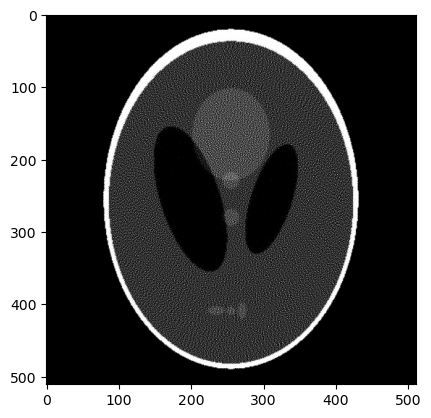

In [9]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

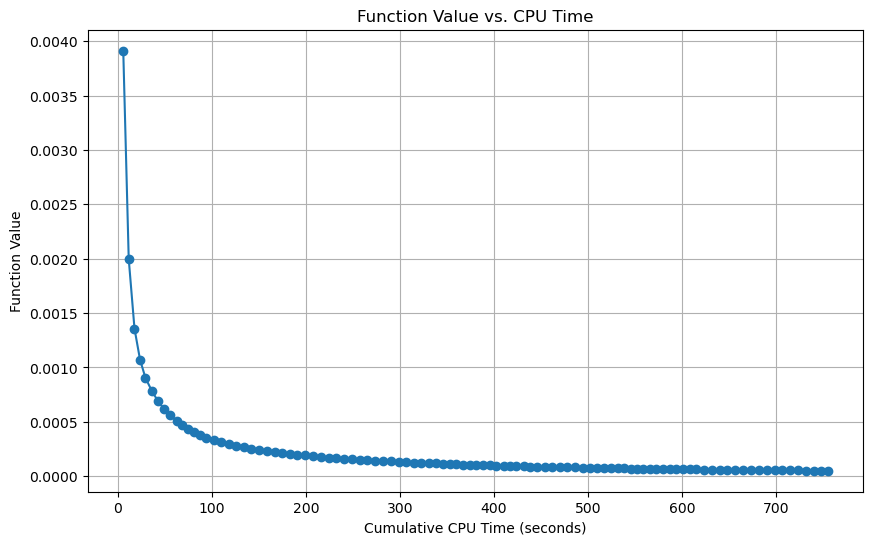

In [10]:
cumaltive_times = [sum(iteration_times[:i+1]) for i in range(len(iteration_times))]
fval = [fval[i]/fhz0 for i in range(100)]


plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times, fval, marker='o', linestyle='-')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.show()

In [13]:
while fh(z0) >= 0.5:
    val = fcts.BSMART(fh, z0, 0.5*tau0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
    assert z0.max() <= 1
    print(i, ': ', fh(z0))
    i += 1

1558 :  tensor(50.5117, dtype=torch.float64, grad_fn=<AddBackward0>)
1559 :  tensor(50.5117, dtype=torch.float64, grad_fn=<AddBackward0>)
1560 :  tensor(50.5117, dtype=torch.float64, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

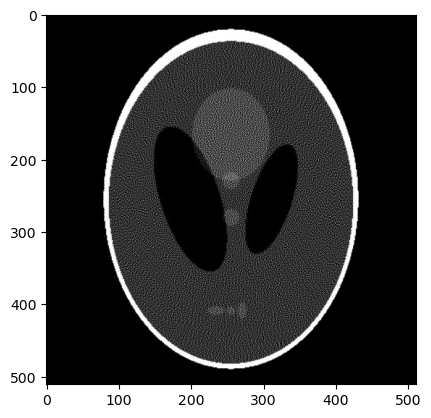

In [11]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')